In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Train, Test
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Métricas
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [5]:
pd.set_option('display.max_columns', None)

In [7]:
# Cargamos el scaler que usamos para escalar los datos previamente

with open('escaladores/x_scaler.pickle', 'rb') as file:
    x_scaler = pickle.load(file)
    
with open('escaladores/y_scaler.pickle', 'rb') as file:
    y_scaler = pickle.load(file)

In [9]:
df = pd.read_csv("../bin/data_process.csv")

In [11]:
# Quitamos el precio nuevo porque a Miguel le parece que es hacer trampa

x = df.drop(columns = ['precio_contado', 'log_precio_nuevo'], axis=1)  
y = df['precio_contado']  

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

In [13]:
modelos = {
    "random_forest": RandomForestRegressor(),
    "decision_tree": DecisionTreeRegressor(),
    "gradient_boosting": GradientBoostingRegressor(),
    "adaboost": AdaBoostRegressor(),
    "kneighbors": KNeighborsRegressor(),
    "linear_regressor": LinearRegression(),
    "svr": SVR()
}

In [25]:
%%time
resultados = []

for regresor, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    
    y_pred = modelo.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1)).ravel()
    y_test_unscaled = y_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
    
    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    
    resultados.append({'Nombre_modelo': regresor, 'MAE': mae, 'MSE': mse, 'R2_score': r2})
    
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by = "R2_score", ascending = False)

CPU times: total: 22.9 s
Wall time: 24.5 s


In [26]:
df_resultados

,Nombre_modelo,MAE,MSE,R2_score
0,random_forest,455.853661,2.178630e+06,0.995035
2,gradient_boosting,843.695914,3.889647e+06,0.991136
1,decision_tree,595.511172,4.368640e+06,0.990044
6,svr,1717.615307,4.810741e+06,0.989037
4,kneighbors,747.621432,5.356487e+06,0.987793
5,linear_regressor,2111.934684,1.197457e+07,0.972711
3,adaboost,3839.862242,2.270781e+07,0.948250


potencia_cv: (0.7576327938900506) 
id_modelo: (0.13994530166480007) 
id_concesionario: (0.04106183068415544) 
antiguedad_coche: (0.021866938690406214) 
peso: (0.006126190014585523) 
log_kilometraje: (0.005723238734471194) 
par: (0.005500055155683816) 
aceleracion: (0.005300075704423116) 
garantia: (0.004547839539220708) 
cilindrada: (0.0023517217794132863) 
volumen: (0.0021475970059311373) 
capacidad_maletero: (0.0010676807789578922) 
ano_matriculacion: (0.0008992322162026352) 
num_marchas: (0.0008494245298702694) 
velocidad_max: (0.0007719190788990257) 
num_cilindros: (0.0007093454448299342) 
batalla: (0.0006726327756526069) 
id_provincia: (0.0006408884977820333) 
deposito: (0.0005761674261285875) 
id_marca: (0.000535609704808459) 
id_distintivo_ambiental_ECO: (0.0004778549467171055) 
tipo_cambio: (0.0002494921673135737) 
id_traccion_total permanente: (8.625858430416367e-05) 
combustible_Gasolina: (5.398404725275912e-05) 
id_distintivo_ambiental_C: (5.059029367005575e-05) 
num_puertas

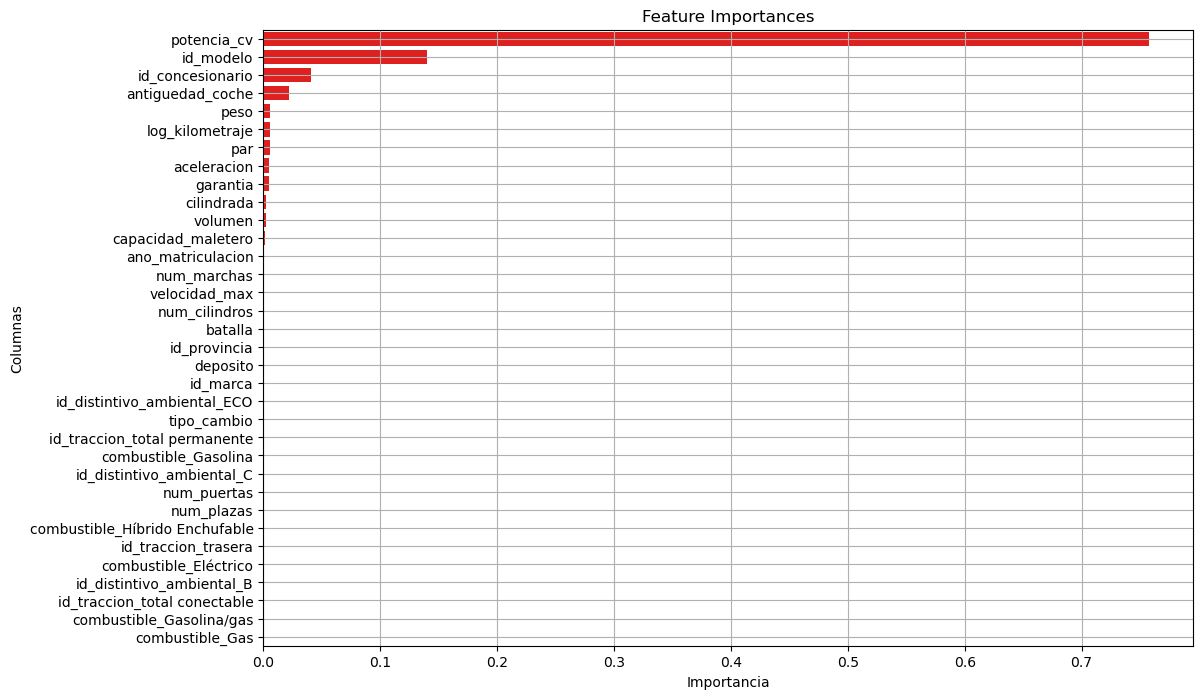

CPU times: total: 30.7 s
Wall time: 33.4 s


In [27]:
%%time
# Modelo de RandomForest para obtener Feature Importance
model = RandomForestRegressor(n_estimators = 250,
                               random_state = 33)
# Entrenamos el modelo
model.fit(x, y)

# Calculamos Feature Importance
importances = model.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [10]:
%%time

scorers = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)}



params = {"n_estimators"           : [100, 150],
          "criterion"              : ["squared_error", "absolute_error"], 
          "max_depth"              : [10, 15],
          "max_leaf_nodes"         : [90, 120],
          "min_samples_split"      : [2, 10],
          "random_state"           : [33]} 

grid_solver = GridSearchCV(estimator  = model     , 
                           param_grid = params    , 
                           scoring    = scorers   ,
                           cv         = 5         ,
                           refit      = "R2",
                           n_jobs     = -1        ,
                           verbose    = 3)

model_result = grid_solver.fit(x, y)

print(model_result.cv_results_["mean_test_MAE"].mean())
print(model_result.cv_results_["mean_test_MSE"].mean())
print(model_result.cv_results_["mean_test_R2"].mean())

print("*" * 100)

print(model_result.best_score_)
print(model_result.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
-0.08132603906105221
-0.01929330239451264
0.9347249068619439
****************************************************************************************************
0.9398757307126958
{'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 33}
CPU times: total: 12.5 s
Wall time: 9h 55min 39s


In [28]:
best_params = {'criterion': 'squared_error', 'max_depth': 15, 'max_leaf_nodes': 120, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 33}

In [29]:
mejor_modelo = RandomForestRegressor(**best_params)

mejor_modelo.fit(x, y)

RandomForestRegressor(max_depth=15, max_leaf_nodes=120, n_estimators=150,
                      random_state=33)

potencia_cv: (0.7632124992138485) 
id_modelo: (0.14062547485163843) 
id_concesionario: (0.04002229002701105) 
antiguedad_coche: (0.02096633894594492) 
peso: (0.006557030905665871) 
par: (0.005205273681558224) 
log_kilometraje: (0.00500343367181904) 
aceleracion: (0.0048684655358380265) 
garantia: (0.004613054788736363) 
cilindrada: (0.001967622029795085) 
volumen: (0.0017910773768487907) 
ano_matriculacion: (0.0008909246052448536) 
capacidad_maletero: (0.0007635827385226968) 
num_marchas: (0.0006636260037749865) 
num_cilindros: (0.0005862292860468597) 
velocidad_max: (0.000448293882308359) 
batalla: (0.00040184496397365074) 
id_provincia: (0.0003095843766643559) 
deposito: (0.0002728794546551752) 
id_distintivo_ambiental_ECO: (0.0002518017859879591) 
id_marca: (0.0002314806829055367) 
tipo_cambio: (0.00020702726754394615) 
id_traccion_total permanente: (4.800037599925356e-05) 
id_distintivo_ambiental_C: (2.6260173262397637e-05) 
num_plazas: (2.3768013712782144e-05) 
combustible_Gasolin

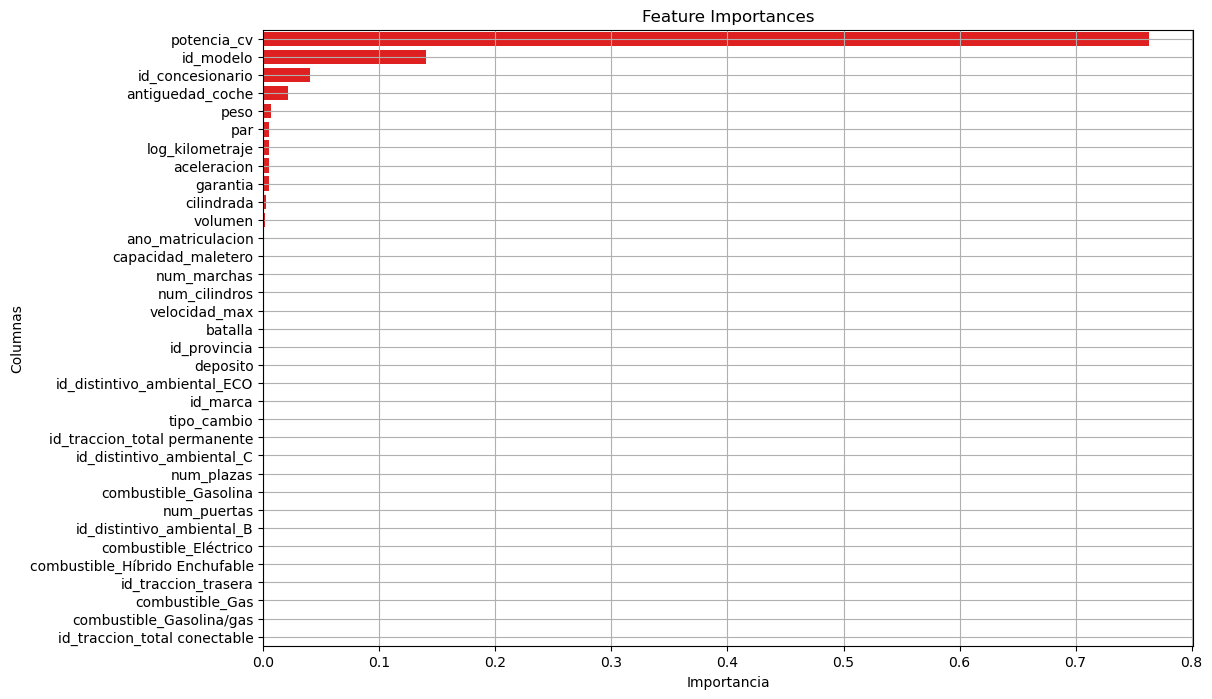

CPU times: total: 219 ms
Wall time: 458 ms


In [30]:
%%time
# Calculamos Feature Importance
importances = mejor_modelo.feature_importances_

df_importances = pd.DataFrame(data = zip(x.columns, importances),
                              columns = ["Columnas", "Importancia"])

df_importances = df_importances.sort_values("Importancia", ascending = False)

for index, (feature, importance) in enumerate(df_importances.values):
    
    print(f"{feature}: ({importance:3}) ")

plt.figure(figsize = (12, 8))

plt.title("Feature Importances")
sns.barplot(x = df_importances["Importancia"], y = df_importances["Columnas"], color = "red")

plt.grid()
plt.show()

In [33]:
#Crear una carpeta para guardar el objeto escalador

os.makedirs("modelo", exist_ok=True)

with open("modelo/mejor_modelo.pkl", "bw") as file:
    pickle.dump(mejor_modelo, file)